In [1]:
import strawberryfields as sf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from utils import *

sf.hbar = 1

# %matplotlib ipympl
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          'font.size': 22,}
matplotlib.rcParams.update(params)

# kvantify_colors = ["#00392f", "#00573f", "#24a926", "#bffd50"]
# # darkgreen, green, lightgreen, brightgreen = kvantify_colors
# green = kvantify_colors[1]
# kvantify_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("Kvantify", kvantify_colors)
# matplotlib.colormaps.register(kvantify_cmap, name="Kvantify")


plt.close('all')

## Check that Steane is indeed a special case of Knill

In [2]:
# Run Knill and Steane circuits using StrawberryFields

epsilon = 0.095  # parameter controlling the quality of GKP states
ampl_cutoff = 1e-3  # relates to numerical accuracy of the simulation

measurement_results = np.array([0.4, 0.1]) * np.sqrt(np.pi)  # (s_q, s_p)
d = (1.8 + 0.5j) * np.sqrt(np.pi)

input = sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d))

# Knill approach
prog = sf.Program(3)
with prog.context as modes:
    input | modes[0]
    
    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[1]
    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[2]
    
    sf.ops.Rgate(+np.pi/2) | modes[1]
    sf.ops.CXgate(+1) | (modes[1], modes[2])
    sf.ops.CXgate(-1) | (modes[1], modes[0])

    sf.ops.MeasureHomodyne(0, select=measurement_results[0]) | modes[0]
    sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[1]

eng = sf.Engine("bosonic")
result_knill = eng.run(prog)

# Steane approach
prog = sf.Program(3)
with prog.context as modes:
    input | modes[0]

    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[1]
    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[2]
    sf.ops.Rgate(np.pi) | modes[2]

    sf.ops.CZgate() | (modes[0], modes[1])
    sf.ops.Rgate(-np.pi/2) | modes[0]
    sf.ops.CZgate() | (modes[0], modes[2])
    sf.ops.Rgate(+np.pi/2) | modes[0]

    sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[0]) | modes[1]
    sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[2]

    s = measurement_results[0] + 1j*measurement_results[1]
    sf.ops.Dgate(np.abs(s)/np.sqrt(2), np.angle(s) + np.pi) | modes[0]

eng = sf.Engine("bosonic")
result_steane = eng.run(prog)

In [3]:
# Compute Wigner functions

window = np.array([-3, 3]) * np.sqrt(np.pi)
resolution = 100  # this number can be increased to get a higher resolution plot. Numerical accuracy is
                  # not affected by this choice since that is determined purely from `ampl_cutoff` above.
                  # We used resolution=500 for the article.

q = np.linspace(window[0], window[1], resolution)
p = q

z_knill = result_knill.state.wigner(2, q, p)
z_steane = result_steane.state.wigner(0, q, p)

q, p = np.meshgrid(q, p)

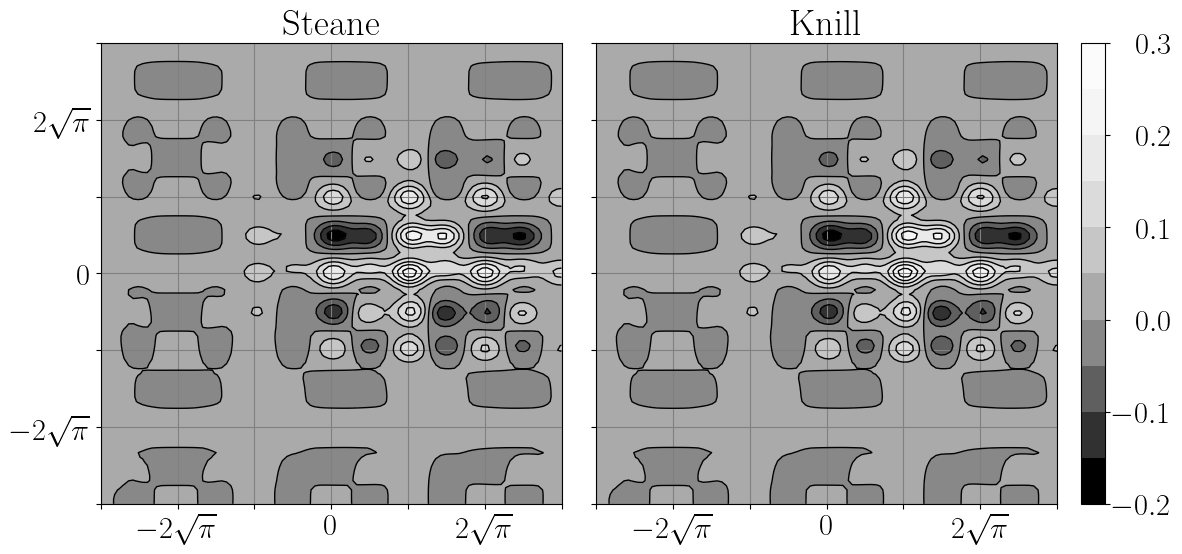

In [4]:
# Plot Wigner functions

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

# set tick marks to multiples of sqrt(pi)
ticks, labels = get_tickmarks(*window)
labels[0]  = ""
labels[-1] = ""

ax = axs[0]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

# plotting
num_contours = 10
# colour mapping
from scipy.stats import norm
mu = 0
sigma = 0.65
mapping = lambda x: norm.cdf(x, loc=mu, scale=sigma**2)

colors = mapping(np.linspace(0, 1, num_contours+1))
colors = (colors - colors[0]) / (colors[-1] - colors[0])
colors = list(map(str, colors))

ax = axs[1]
# ax.contourf(q, p, z_knill, num_contours, colors=color_str)
ax.contourf(q, p, z_knill, num_contours, colors=colors)
ax.contour(q, p, z_knill, num_contours, colors="black", linestyles="solid", linewidths=1)
ax.set_aspect('equal', adjustable='box')
ax.title.set_text('Knill')
ax.grid(color="0.5")

ax = axs[0]
# cs = ax.contourf(q, p, z_steane, num_contours, colors=color_str)
cs = ax.contourf(q, p, z_steane, num_contours, colors=colors)
ax.contour(q, p, z_steane, num_contours, colors="black", linestyles="solid", linewidths=1)
ax.set_aspect('equal', adjustable='box')
ax.title.set_text('Steane')
ax.grid(color="0.5")

fig.tight_layout()

# make room for new axis
fig.subplots_adjust(right=0.9)
# make axis that is same height as plots
ax = axs[1]
cax = fig.add_axes([
    ax.get_position().x1 + 0.02,
    ax.get_position().y0,
    0.02,
    ax.get_position().height,
])
cbar = fig.colorbar(cs, cax=cax)
# align tick labels to the right so that labels align vertically regardles of their sign
plt.setp(cbar.ax.get_yticklabels(), ha="right")
cbar.ax.tick_params(pad=45)

# plt.savefig("wigner_functions.pdf", format="pdf")
plt.show()

Maximal error: 6.114063196005493e-08


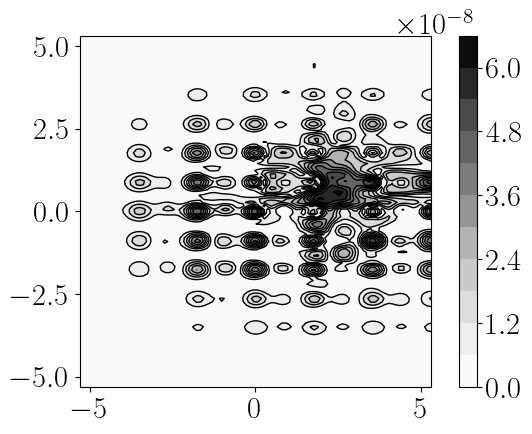

In [5]:
# Plot difference of Wigner function

difference = np.abs(z_knill - z_steane)

fig = plt.figure()
ax = plt.subplot()
cs = ax.contourf(q, p, difference, num_contours, cmap="Grays")
ax.contour(q, p, difference, num_contours, colors="black", linestyles="solid", linewidths=1)
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cs)
plt.tight_layout()

print("Maximal error:", np.max(difference))
plt.show()

## Plot GKP states

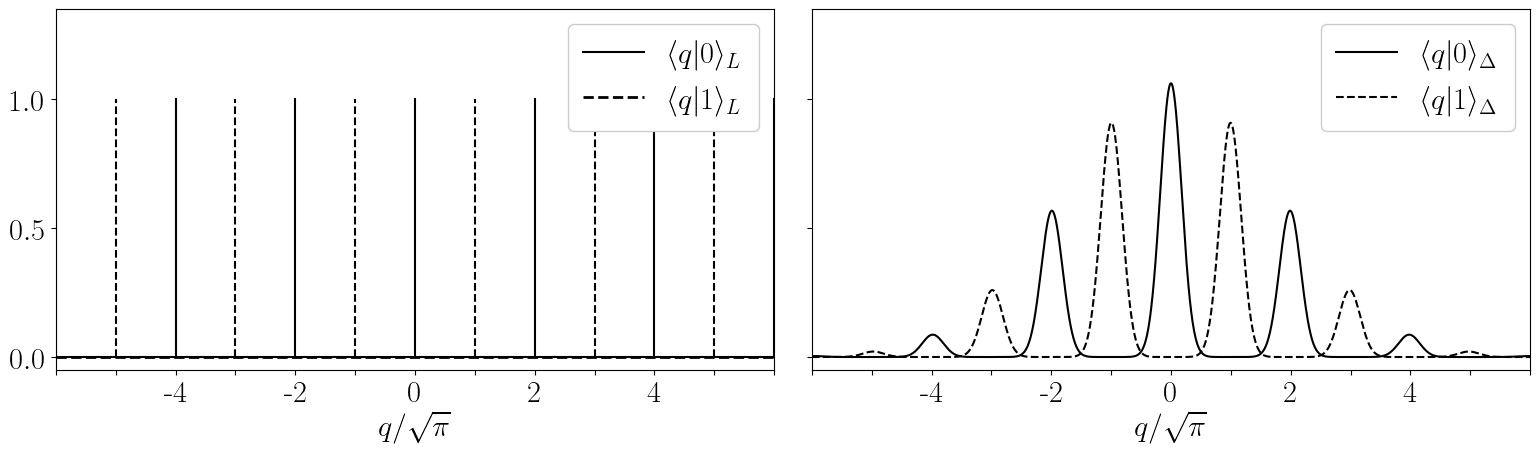

In [6]:
# Plot ideal and approximate GKP basis states
epsilon = 0.1
span = np.array([-6, 6]) * np.sqrt(np.pi)
qs = np.linspace(*span, 1500)
ticks, ticklabels = get_tickmarks(*span, True)

zero = gkp(qs, epsilon, [1, 0]).real
one  = gkp(qs, epsilon, [0, 1]).real
zero = normalise(qs, zero)
one = normalise(qs, one)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 5))
# fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(8, 8))
axs[1].plot(qs, zero, "k-", label = r"$\langle q | 0 \rangle_\Delta$")
axs[1].plot(qs, one, "k--", label = r"$\langle q | 1 \rangle_\Delta$")

axs[0].plot(span, [0, 0], "k-" , label = r"$\langle q | 0 \rangle_L$")
axs[0].plot(span, [0, 0], "k--", label = r"$\langle q | 1 \rangle_L$", linewidth=2)
for i, x in enumerate(ticks):
    if i % 2 == 0:
        axs[0].plot([x, x], [0, 1], "k-")
    else:
        axs[0].plot([x, x], [0, 1], "k--")

ticklabels[0]  = ""
ticklabels[-1] = ""

axs[0].set_xticks(ticks)
axs[0].set_xticklabels(ticklabels)
axs[0].set_xlim(*span)
axs[0].set_ylim(-0.05, 1.35)

axs[0].legend(loc="upper right", framealpha=1, borderpad=0.5)
axs[1].legend(loc="upper right", framealpha=1, borderpad=0.5)

axs[0].set_xlabel(r"$q / \sqrt{\pi}$")
axs[1].set_xlabel(r"$q / \sqrt{\pi}$")
# axs[0].set_ylabel(r"$\psi(q) = \langle q | \psi \rangle$")

plt.tight_layout()
# plt.savefig("gkp_states.pdf", format="pdf")
plt.show()

## Simulation of perfect CV operations implementing imperfect logical gates

In [7]:
# Single-mode example of imperfect gate (P gate)

epsilon = 0.1
qs = np.linspace(-15, 15, 1000)
dq = (qs[-1] - qs[0]) / len(qs)

plus = normalise(qs, gkp(qs, epsilon, [1, 1]))
zero = normalise(qs, gkp(qs, epsilon, [1, 0]))
init = plus

# Initial state
state = init
print("Logical fidelity:", logical_fidelity(qs, state))
plot_single_mode(qs, state)
plt.show()

# Apply P-gate
state = state * np.exp(0.5j * qs**2)
print("Logical fidelity:", logical_fidelity(qs, state))
plot_single_mode(qs, state)
plt.show()

# Apply GKP projector
state = gkp_project_sym(qs, state, plus, zero)
state = normalise(qs, state)
print("Logical fidelity:", logical_fidelity(qs, state))
plot_single_mode(qs, state)
plt.show()

Logical fidelity: 0.9988543005872196


NameError: name 'plt' is not defined

Logical fidelity: 0.9933489480261808


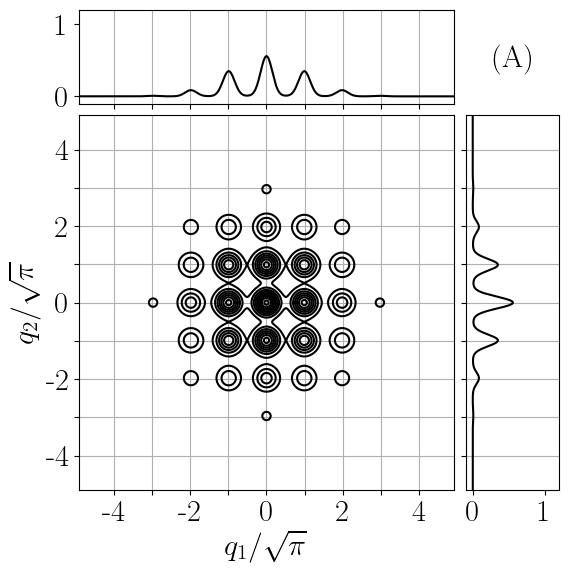

Logical fidelity: 0.9542939303000988


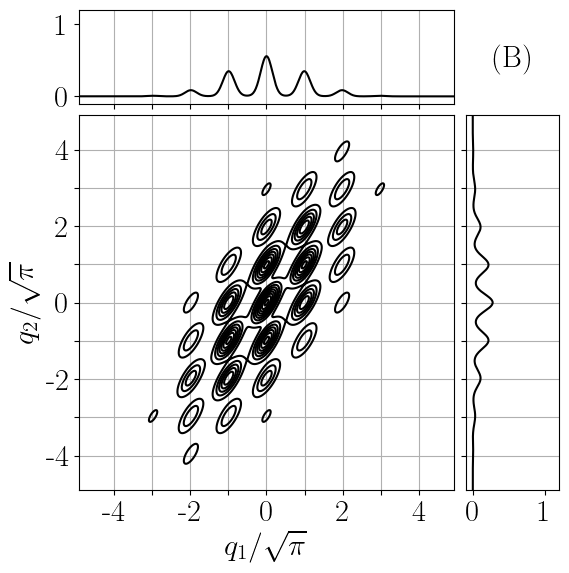

Logical fidelity: 0.993349442544092


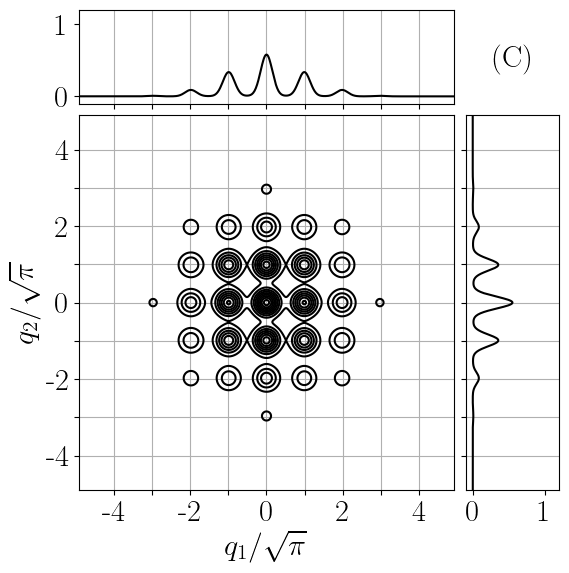

In [51]:
# Two-mode example of imperfect gate (CX gate)

from scipy.interpolate import RegularGridInterpolator

epsilon = 0.15
qs = np.linspace(-15, 15, 1000)
dq = (qs[-1] - qs[0]) / len(qs)

plus = normalise(qs, gkp(qs, epsilon, [1, 1]))
zero = normalise(qs, gkp(qs, epsilon, [1, 0]))
one  = normalise(qs, gkp(qs, epsilon, [0, 1]))

def fix_axes(axs):
    # Fix axis limits
    window = np.array([-1, 1]) * 4.9*np.sqrt(np.pi)
    proj_lim = [-0.1, 1.2]
    axs[0].set_xlim(*window)
    axs[0].set_ylim(*window)
    axs[1].set_ylim(*proj_lim)
    axs[2].set_xlim(*proj_lim)


init = np.einsum("i,j -> ij", plus, plus)

state = init
print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(A)', fontsize=22)
# plt.savefig("gate_example01.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply two controlled displacements: CX^2
x, y = np.meshgrid(qs, qs, indexing="ij")
xp, yp = x, y-1*x
fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
state = fun((xp, yp))

print("Logical fidelity:", logical_fidelity(qs, state))
temp = state.copy()  # used to prettify plot only
temp[np.abs(state) < 1e-6] = 1e-6
_, axs = plot_two_mode(qs, qs, np.abs(temp), True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(B)', fontsize=22)
# plt.savefig("gate_example02.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply GKP projector to both modes
state = gkp_project_sym(qs, state, zero, one, 0)
state = gkp_project_sym(qs, state, zero, one, 1)
norm = np.sqrt(np.einsum("ij,ij", state, state.conj()) * dq**2)
state /= norm

print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, np.abs(state), True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(C)', fontsize=22)
# plt.savefig("gate_example03.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Plot the two types of Bell state

Logical fidelity: 0.35523627653283907


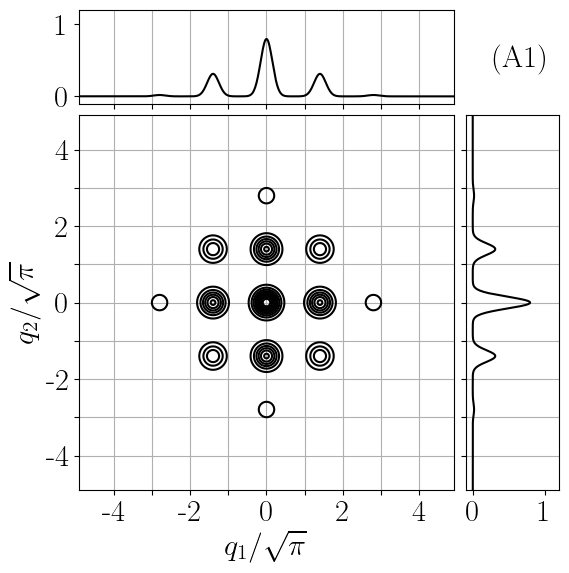

Logical fidelity: 0.988680615395366


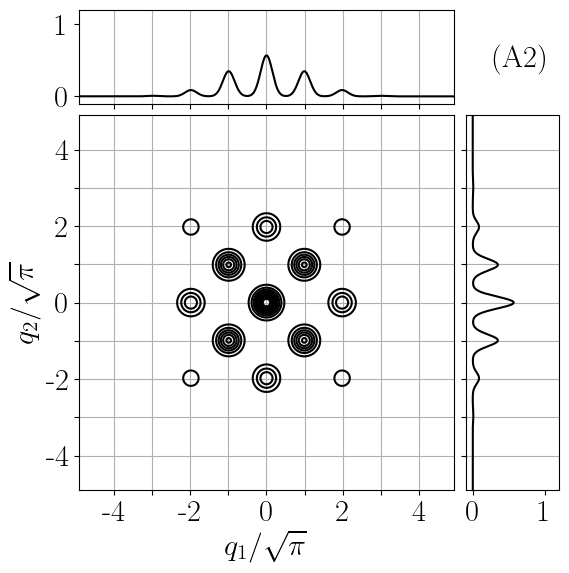

Logical fidelity: 0.9943402593548367


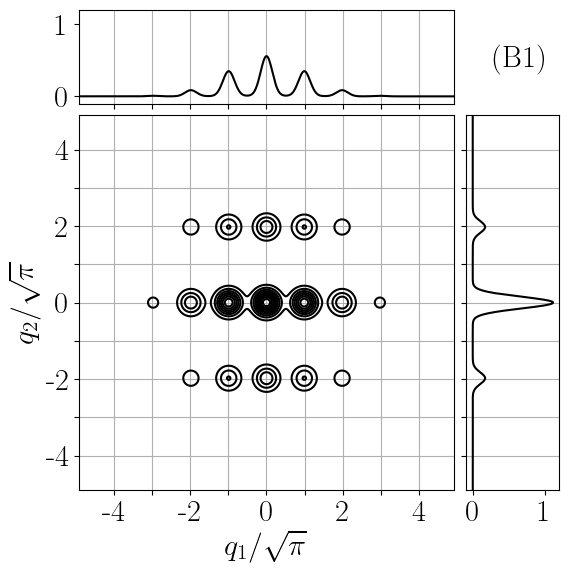

Logical fidelity: 0.906584192948888


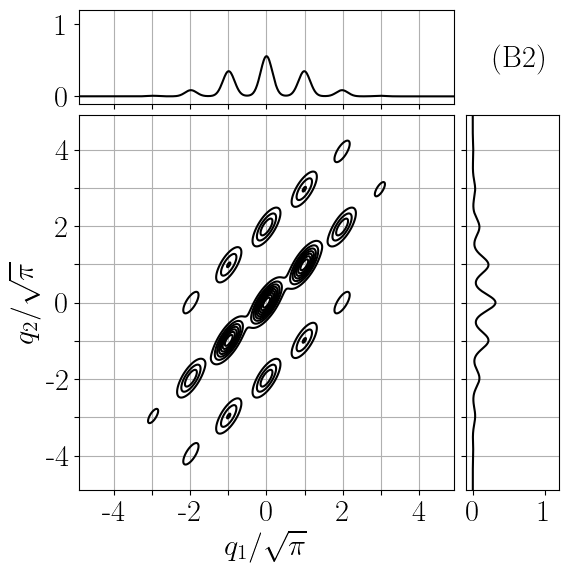

In [52]:
# Knill vs. qunaught error correction

from scipy.interpolate import RegularGridInterpolator

epsilon = 0.15
qs = np.linspace(-15, 15, 1000)
dq = (qs[-1] - qs[0]) / len(qs)

plus = normalise(qs, gkp(qs, epsilon, [1, 1]))
zero = normalise(qs, gkp(qs, epsilon, [1, 0]))
qunaught = normalise(qs, comb(qs, epsilon, np.sqrt(2*np.pi)))

def fix_axes(axs):
    # Fix axis limits
    window = np.array([-1, 1]) * 4.9*np.sqrt(np.pi)
    proj_lim = [-0.1, 1.2]
    axs[0].set_xlim(*window)
    axs[0].set_ylim(*window)
    axs[1].set_ylim(*proj_lim)
    axs[2].set_xlim(*proj_lim)



# Bell state from qunaught states
state = np.einsum("i,j -> ij", qunaught, qunaught)

print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(A1)', fontsize=22)
# plt.savefig("bellA1.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply beam splitter (rotate in 2-D position space)
theta = np.pi/4
x, y = np.meshgrid(qs, qs)
xp, yp = np.cos(-theta) * x - np.sin(-theta) * y, np.sin(-theta) * x + np.cos(-theta) * y
fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
state = fun((xp, yp))

print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(A2)', fontsize=22)
# plt.savefig("bellA2.pdf", format="pdf", bbox_inches='tight')
plt.show()


# Bell state from GKP states
init = np.einsum("i,j -> ij", plus, zero)

state = init
print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(B1)', fontsize=22)
# plt.savefig("bellB1.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply controlled displacement: CX
x, y = np.meshgrid(qs, qs, indexing="ij")
xp, yp = x, y-x
fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
state = fun((xp, yp))

print("Logical fidelity:", logical_fidelity(qs, state))
temp = state.copy()  # used to prettify plot only
temp[np.abs(state) < 1e-6] = 1e-6
_, axs = plot_two_mode(qs, qs, np.abs(temp), True)
fix_axes(axs)
axs[1].text(10.5, 0.4, r'(B2)', fontsize=22)
# plt.savefig("bellB2.pdf", format="pdf", bbox_inches='tight')
plt.show()
